# Data Science in Healthcare

## Project 2 - Cancer Survival Analysis

#### Submitted by: Sakshi Shende

Refer to the attached cancer patient data:
[Cancer patient data.xlsx](https://docs.google.com/spreadsheets/d/1wQpAmWjaOa5WnnLvOVLa-KbHWYw-Yp8y/edit?usp=drive_web&ouid=115447949975025990201&rtpof=true)

Columns denote different types of cancer.

Columns ending with _DT are the dates of cancer diagnosis.

For each column, a 1 (or 0) indicates patient has (does not have) that type of cancer.

Calculate the age of each patient at the time of cancer diagnosis.

Analyze survival rate by gender, race and age group in deciles (11-20, 21-30, ....) for patients with following cancer:
1. lung
2. pancreas
3. thyroid
4. colorectal
5. melanoma


**Note**

1. Use 8/25/16 as the end date of the analysis.

2. Remove all diagnosis after 8/25/16.

3. Keep patients who died after 8/25/16 (you need to censor this data).

4. Remove all patients who do not have a diagnosis date.

5. Categorize race into White, African-American, Asian/Mideast-Indian, and Others.

6. Patients with more than 1 cancer - treat them as independent data points for each cancer type

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install lifelines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.7/350.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 10.3 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=75a62397d81189a37bb7fb5bf008a22b142c5f9674df60ecf6878080b2a686eb
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [6]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from lifelines import KaplanMeierFitter
from lifelines.plotting import plot_lifetimes

## Import the data

In [7]:
patient_data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Data Science in Healthcare/Cancer Survival Analysis/Cancer patient data.xlsx')
print(patient_data.shape)
patient_data.head()

(8468, 14)


,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,PANCREAS,THYROID,COLORECTAL,MELANOMA,LUNG DT,PANCREAS_DT,THYROID_DT,COLORECTAL_DT,MELANOMA_DT
0,1959-12-02,NaT,Male,Black/African-American,1,0,0,0,0,2013-09-01,NaT,NaT,NaT,NaT
1,1955-11-18,2016-04-20,Male,Black/African-American,1,0,0,0,0,2016-04-02,NaT,NaT,NaT,NaT
2,1946-01-14,2015-05-25,Female,Black/African-American,1,0,0,0,0,2015-04-11,NaT,NaT,NaT,NaT
3,1932-07-28,NaT,Female,Black/African-American,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT
4,1943-04-17,NaT,Male,White,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT


## Data Preprocessing

In [8]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8468 entries, 0 to 8467
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   BIRTH_DATE_off  8468 non-null   datetime64[ns]
 1   DEATH_DATE_off  447 non-null    datetime64[ns]
 2   sex             8468 non-null   object        
 3   race            8466 non-null   object        
 4   LUNG            8468 non-null   int64         
 5   PANCREAS        8468 non-null   int64         
 6   THYROID         8468 non-null   int64         
 7   COLORECTAL      8468 non-null   int64         
 8   MELANOMA        8468 non-null   int64         
 9   LUNG DT         1485 non-null   datetime64[ns]
 10  PANCREAS_DT     660 non-null    datetime64[ns]
 11  THYROID_DT      745 non-null    datetime64[ns]
 12  COLORECTAL_DT   946 non-null    datetime64[ns]
 13  MELANOMA_DT     346 non-null    datetime64[ns]
dtypes: datetime64[ns](7), int64(5), object(2)
memory usage: 

Define the end date of the analysis

In [9]:
end_date = pd.to_datetime('8/25/16')
end_date

Timestamp('2016-08-25 00:00:00')

Remove all diagnosis after 8/25/16

In [10]:
filtered_data = (patient_data['COLORECTAL_DT'] > end_date) | (patient_data['LUNG DT'] > end_date) | (patient_data['MELANOMA_DT'] > end_date) | (patient_data['PANCREAS_DT'] > end_date) | (patient_data['THYROID_DT'] > end_date)
filtered_data.shape

(8468,)

In [11]:
print(patient_data[filtered_data].shape)
patient_data[filtered_data]

(5, 14)


,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,PANCREAS,THYROID,COLORECTAL,MELANOMA,LUNG DT,PANCREAS_DT,THYROID_DT,COLORECTAL_DT,MELANOMA_DT
82,1939-12-09,NaT,Female,Black/African-American,1,0,0,0,0,2016-09-05,NaT,NaT,NaT,NaT
174,1946-05-02,NaT,Male,White,1,0,0,0,0,2016-09-05,NaT,NaT,NaT,NaT
1587,1943-12-05,NaT,Female,White,0,1,0,0,0,NaT,2016-09-01,NaT,NaT,NaT
1905,1937-03-24,NaT,Female,White,0,1,0,0,0,NaT,2016-09-04,NaT,NaT,NaT
5226,1977-03-12,NaT,Female,White,0,0,1,0,0,NaT,NaT,2016-09-26,NaT,NaT


The above dataframe shows the information about the patients whose diagnosis is after 8/25/16.

Remove these 5 rows from the original dataset to get the diagnosis before 8/25/16

In [12]:
patient_data = patient_data[~filtered_data]
print(patient_data.shape)
patient_data.head()

(8463, 14)


,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,PANCREAS,THYROID,COLORECTAL,MELANOMA,LUNG DT,PANCREAS_DT,THYROID_DT,COLORECTAL_DT,MELANOMA_DT
0,1959-12-02,NaT,Male,Black/African-American,1,0,0,0,0,2013-09-01,NaT,NaT,NaT,NaT
1,1955-11-18,2016-04-20,Male,Black/African-American,1,0,0,0,0,2016-04-02,NaT,NaT,NaT,NaT
2,1946-01-14,2015-05-25,Female,Black/African-American,1,0,0,0,0,2015-04-11,NaT,NaT,NaT,NaT
3,1932-07-28,NaT,Female,Black/African-American,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT
4,1943-04-17,NaT,Male,White,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT


Keep patients who died after 8/25/16 (you need to censor this data).

In [13]:
# Define the censoring date
censoring_date = pd.to_datetime('8/25/16')
censoring_date

Timestamp('2016-08-25 00:00:00')

To censor the data, I'm creating a column called "Censored"

* 0 indicates that the patient ends the study alive and patient dies after 8/25/16
* 1 indicates that the patient died during the study

In [14]:
# Create a 'Censored' column based on whether patients are censored (0) or not (1)
patient_data['Censored'] = 0

# Update the censored column based on the conditions specified above
patient_data.loc[patient_data['DEATH_DATE_off'] > censoring_date, 'Censored'] = 0
patient_data.loc[patient_data['DEATH_DATE_off'] <= censoring_date, 'Censored'] = 1

In [15]:
patient_data['Censored'].value_counts()

0    8063
1     400
Name: Censored, dtype: int64

Remove all patients who do not have a diagnosis date.

In [16]:
patient_data.columns

Index(['BIRTH_DATE_off', 'DEATH_DATE_off', 'sex', 'race', 'LUNG', 'PANCREAS',
       'THYROID', 'COLORECTAL', 'MELANOMA', 'LUNG DT', 'PANCREAS_DT',
       'THYROID_DT', 'COLORECTAL_DT', 'MELANOMA_DT', 'Censored'],
      dtype='object')

In [17]:
diagnosis_date = ['LUNG DT', 'PANCREAS_DT', 'THYROID_DT', 'COLORECTAL_DT', 'MELANOMA_DT']

# identify the number of patients without a dignosis date
patient_data[diagnosis_date].isna().sum()

LUNG DT          6980
PANCREAS_DT      7805
THYROID_DT       7719
COLORECTAL_DT    7517
MELANOMA_DT      8117
dtype: int64

In [18]:
patient_data = patient_data[(patient_data['LUNG DT'].notnull()) | (patient_data['PANCREAS_DT'].notnull()) | (patient_data['THYROID_DT'].notnull()) | (patient_data['COLORECTAL_DT'].notnull()) | (patient_data['MELANOMA_DT'].notnull())]
print(patient_data.shape)
patient_data.head()

(4148, 15)


,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,PANCREAS,THYROID,COLORECTAL,MELANOMA,LUNG DT,PANCREAS_DT,THYROID_DT,COLORECTAL_DT,MELANOMA_DT,Censored
0,1959-12-02,NaT,Male,Black/African-American,1,0,0,0,0,2013-09-01,NaT,NaT,NaT,NaT,0
1,1955-11-18,2016-04-20,Male,Black/African-American,1,0,0,0,0,2016-04-02,NaT,NaT,NaT,NaT,1
2,1946-01-14,2015-05-25,Female,Black/African-American,1,0,0,0,0,2015-04-11,NaT,NaT,NaT,NaT,1
6,1946-11-03,NaT,Female,Black/African-American,0,0,1,0,0,NaT,NaT,2012-11-29,NaT,NaT,0
7,1938-06-10,NaT,Female,Black/African-American,0,0,1,0,0,NaT,NaT,2012-06-24,NaT,NaT,0


 Categorize race into White, African-American, Asian/Mideast-Indian, and Others.

In [19]:
patient_data['race'].value_counts()

White                                     2815
Black/African-American                     956
Unknown                                    163
Asian/Mideast Indian                       117
More than one Race                          49
Patient Declined                            25
Native Hawaiian/Other Pacific Islander      17
American Indian or Alaska Native             4
Name: race, dtype: int64

In [20]:
patient_data['race'].isna().sum()

2

In [21]:
def categorize_race(race):
    if pd.isna(race):
        return 'Others'
    elif race == 'White':
        return 'White'
    elif race == 'Black/African-American':
        return 'African-American'
    elif race == 'Asian/Mideast Indian':
        return 'Asian/Mideast-Indian'
    else:
        return 'Others'

patient_data['race'] = patient_data['race'].apply(categorize_race)
patient_data['race'].value_counts()

White                   2815
African-American         956
Others                   260
Asian/Mideast-Indian     117
Name: race, dtype: int64

Patients with more than 1 cancer - treat them as independent data points for each cancer type



In [22]:
# Identify the number of patients with more than 1 cancer
patient_data['Cancer_count'] = patient_data['LUNG'] + patient_data['PANCREAS'] + patient_data['COLORECTAL'] + patient_data['MELANOMA'] + patient_data['THYROID']
patient_data['Cancer_count'].value_counts()

1    4119
2      29
Name: Cancer_count, dtype: int64

In [23]:
print(f'There are {len(patient_data[patient_data["Cancer_count"] != 1])} patients who have more than 1 cancer')

There are 29 patients who have more than 1 cancer


In [24]:
# Display records of these 29 patients
patient_data[patient_data['Cancer_count'] != 1]

,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,PANCREAS,THYROID,COLORECTAL,MELANOMA,LUNG DT,PANCREAS_DT,THYROID_DT,COLORECTAL_DT,MELANOMA_DT,Censored,Cancer_count
41,1928-03-25,NaT,Female,African-American,1,0,0,1,0,2012-02-22,NaT,NaT,2013-12-11,NaT,0,2
164,1924-11-30,NaT,Female,African-American,1,0,0,1,0,2013-02-04,NaT,NaT,2013-01-14,NaT,0,2
308,1954-04-20,NaT,Female,African-American,0,0,1,1,0,NaT,NaT,2015-05-06,2010-12-04,NaT,0,2
557,1942-11-10,NaT,Female,White,1,0,0,1,0,2013-09-14,NaT,NaT,2013-08-16,NaT,0,2
611,1955-03-23,NaT,Male,White,0,1,0,0,1,NaT,2014-02-14,NaT,NaT,2013-12-13,0,2
1087,1936-02-24,NaT,Male,White,0,1,0,0,1,NaT,2011-03-28,NaT,NaT,2012-03-21,0,2
1467,1951-07-25,NaT,Female,White,1,0,0,1,0,2012-05-22,NaT,NaT,2012-05-12,NaT,0,2
1490,1947-06-02,2016-02-10,Male,Others,1,0,1,0,0,2013-12-27,NaT,2014-09-05,NaT,NaT,1,2
1510,1940-05-24,NaT,Male,White,1,0,0,1,0,2014-07-21,NaT,NaT,2011-10-09,NaT,0,2
1660,1931-09-09,NaT,Female,White,1,0,1,0,0,2013-08-27,NaT,2013-08-16,NaT,NaT,0,2


In [25]:
patient_data['Censored'].value_counts()

0    3851
1     297
Name: Censored, dtype: int64

Create dataset for each cancer type

### LUNG

In [26]:
lung_df = patient_data[patient_data['LUNG'] == 1]
lung_df.drop(columns = ['PANCREAS', 'THYROID',	'COLORECTAL',	'MELANOMA', 'PANCREAS_DT', 'THYROID_DT', 'COLORECTAL_DT', 'MELANOMA_DT', 'Cancer_count'], axis = 1, inplace=True)
print(lung_df.shape)
lung_df.head()

(1483, 7)


,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,LUNG DT,Censored
0,1959-12-02,NaT,Male,African-American,1,2013-09-01,0
1,1955-11-18,2016-04-20,Male,African-American,1,2016-04-02,1
2,1946-01-14,2015-05-25,Female,African-American,1,2015-04-11,1
9,1957-10-18,NaT,Male,African-American,1,2012-11-29,0
12,1940-02-04,NaT,Male,African-American,1,2013-05-21,0


In [27]:
# Calculate the age at diagnosis
lung_df['Age_At_Diagnosis'] = ((lung_df['LUNG DT'] - lung_df['BIRTH_DATE_off'])/365).astype(str).str[:2].astype(int)
lung_df.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,LUNG DT,Censored,Age_At_Diagnosis
0,1959-12-02,NaT,Male,African-American,1,2013-09-01,0,53
1,1955-11-18,2016-04-20,Male,African-American,1,2016-04-02,1,60
2,1946-01-14,2015-05-25,Female,African-American,1,2015-04-11,1,69
9,1957-10-18,NaT,Male,African-American,1,2012-11-29,0,55
12,1940-02-04,NaT,Male,African-American,1,2013-05-21,0,73


In [28]:
# Calculate the duration
lung_df.loc[lung_df['DEATH_DATE_off'].isna(), 'Survival_Time'] = censoring_date - lung_df['LUNG DT']
lung_df.loc[lung_df['DEATH_DATE_off'].notnull(), 'Survival_Time'] = lung_df['DEATH_DATE_off'] - lung_df['LUNG DT']
lung_df['Survival_Time'] = lung_df['Survival_Time'].astype(str).str[:-5].astype(int)

lung_df.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,LUNG DT,Censored,Age_At_Diagnosis,Survival_Time
0,1959-12-02,NaT,Male,African-American,1,2013-09-01,0,53,1089
1,1955-11-18,2016-04-20,Male,African-American,1,2016-04-02,1,60,18
2,1946-01-14,2015-05-25,Female,African-American,1,2015-04-11,1,69,44
9,1957-10-18,NaT,Male,African-American,1,2012-11-29,0,55,1365
12,1940-02-04,NaT,Male,African-American,1,2013-05-21,0,73,1192


### PANCREAS

In [29]:
pancreas_df = patient_data[patient_data['PANCREAS'] == 1]
pancreas_df.drop(columns = ['LUNG', 'THYROID',	'COLORECTAL',	'MELANOMA', 'LUNG DT', 'THYROID_DT', 'COLORECTAL_DT', 'MELANOMA_DT', 'Cancer_count'], axis = 1, inplace=True)

# Calculate the age at diagnosis
pancreas_df['Age_At_Diagnosis'] = ((pancreas_df['PANCREAS_DT'] - pancreas_df['BIRTH_DATE_off'])/365).astype(str).str[:2].astype(int)

# Calculate the duration
pancreas_df.loc[pancreas_df['DEATH_DATE_off'].isna(), 'Survival_Time'] = censoring_date - pancreas_df['PANCREAS_DT']
pancreas_df.loc[pancreas_df['DEATH_DATE_off'].notnull(), 'Survival_Time'] = pancreas_df['DEATH_DATE_off'] - pancreas_df['PANCREAS_DT']
pancreas_df['Survival_Time'] = pancreas_df['Survival_Time'].astype(str).str[:-5].astype(int)

print(pancreas_df.shape)
pancreas_df.head()

(658, 9)


,BIRTH_DATE_off,DEATH_DATE_off,sex,race,PANCREAS,PANCREAS_DT,Censored,Age_At_Diagnosis,Survival_Time
44,1955-03-10,2012-11-22,Female,African-American,1,2012-10-12,1,57,41
55,1929-06-27,NaT,Female,African-American,1,2016-01-27,0,86,211
57,1938-06-24,NaT,Male,White,1,2013-11-19,0,75,1010
92,1952-08-30,2016-11-21,Male,African-American,1,2014-10-27,0,62,756
118,1956-07-15,2016-04-22,Male,African-American,1,2016-03-13,1,59,40


In [30]:
pancreas_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 658 entries, 44 to 8420
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BIRTH_DATE_off    658 non-null    datetime64[ns]
 1   DEATH_DATE_off    44 non-null     datetime64[ns]
 2   sex               658 non-null    object        
 3   race              658 non-null    object        
 4   PANCREAS          658 non-null    int64         
 5   PANCREAS_DT       658 non-null    datetime64[ns]
 6   Censored          658 non-null    int64         
 7   Age_At_Diagnosis  658 non-null    int64         
 8   Survival_Time     658 non-null    int64         
dtypes: datetime64[ns](3), int64(4), object(2)
memory usage: 67.6+ KB


### THYROID

In [31]:
thyroid_df = patient_data[patient_data['THYROID'] == 1]
thyroid_df.drop(columns = ['LUNG', 'PANCREAS',	'COLORECTAL',	'MELANOMA', 'LUNG DT', 'PANCREAS_DT', 'COLORECTAL_DT', 'MELANOMA_DT', 'Cancer_count'], axis = 1, inplace=True)

# Calculate the age at diagnosis
thyroid_df['Age_At_Diagnosis'] = ((thyroid_df['THYROID_DT'] - thyroid_df['BIRTH_DATE_off'])/365).astype(str).str[:2].astype(int)

# Calculate the survival time
thyroid_df.loc[thyroid_df['DEATH_DATE_off'].isna(), 'Survival_Time'] = censoring_date - thyroid_df['THYROID_DT']
thyroid_df.loc[thyroid_df['DEATH_DATE_off'].notnull(), 'Survival_Time'] = thyroid_df['DEATH_DATE_off'] - thyroid_df['THYROID_DT']
thyroid_df['Survival_Time'] = thyroid_df['Survival_Time'].astype(str).str[:-5].astype(int)

print(thyroid_df.shape)
thyroid_df.head()

(744, 9)


,BIRTH_DATE_off,DEATH_DATE_off,sex,race,THYROID,THYROID_DT,Censored,Age_At_Diagnosis,Survival_Time
6,1946-11-03,NaT,Female,African-American,1,2012-11-29,0,66,1365
7,1938-06-10,NaT,Female,African-American,1,2012-06-24,0,74,1523
28,1948-02-17,NaT,Female,African-American,1,2012-09-02,0,64,1453
32,1949-09-04,NaT,Female,White,1,2014-03-19,0,64,890
98,1949-12-15,NaT,Female,African-American,1,2013-02-26,0,63,1276


In [32]:
thyroid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 744 entries, 6 to 8463
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BIRTH_DATE_off    744 non-null    datetime64[ns]
 1   DEATH_DATE_off    8 non-null      datetime64[ns]
 2   sex               744 non-null    object        
 3   race              744 non-null    object        
 4   THYROID           744 non-null    int64         
 5   THYROID_DT        744 non-null    datetime64[ns]
 6   Censored          744 non-null    int64         
 7   Age_At_Diagnosis  744 non-null    int64         
 8   Survival_Time     744 non-null    int64         
dtypes: datetime64[ns](3), int64(4), object(2)
memory usage: 74.3+ KB


### COLORECTAL

In [33]:
colorectal_df = patient_data[patient_data['COLORECTAL'] == 1]
colorectal_df.drop(columns = ['LUNG', 'PANCREAS',	'THYROID',	'MELANOMA', 'LUNG DT', 'PANCREAS_DT', 'THYROID_DT', 'MELANOMA_DT', 'Cancer_count'], axis = 1, inplace=True)

# Calculate the age at diagnosis
colorectal_df['Age_At_Diagnosis'] = ((colorectal_df['COLORECTAL_DT'] - colorectal_df['BIRTH_DATE_off'])/365).astype(str).str[:2].astype(int)

# Calculate the duration
colorectal_df.loc[colorectal_df['DEATH_DATE_off'].isna(), 'Survival_Time'] = censoring_date - colorectal_df['COLORECTAL_DT']
colorectal_df.loc[colorectal_df['DEATH_DATE_off'].notnull(), 'Survival_Time'] = colorectal_df['DEATH_DATE_off'] - colorectal_df['COLORECTAL_DT']
colorectal_df['Survival_Time'] = colorectal_df['Survival_Time'].astype(str).str[:-5].astype(int)

print(colorectal_df.shape)
colorectal_df.head()

(946, 9)


,BIRTH_DATE_off,DEATH_DATE_off,sex,race,COLORECTAL,COLORECTAL_DT,Censored,Age_At_Diagnosis,Survival_Time
13,1971-08-11,NaT,Female,African-American,1,2014-01-01,0,42,967
14,1948-03-22,2016-01-07,Female,African-American,1,2014-09-30,1,66,464
16,1946-01-09,NaT,Female,African-American,1,2013-09-14,0,67,1076
36,1970-12-19,NaT,Female,White,1,2013-12-09,0,43,990
41,1928-03-25,NaT,Female,African-American,1,2013-12-11,0,85,988


In [34]:
colorectal_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 946 entries, 13 to 8452
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BIRTH_DATE_off    946 non-null    datetime64[ns]
 1   DEATH_DATE_off    64 non-null     datetime64[ns]
 2   sex               946 non-null    object        
 3   race              946 non-null    object        
 4   COLORECTAL        946 non-null    int64         
 5   COLORECTAL_DT     946 non-null    datetime64[ns]
 6   Censored          946 non-null    int64         
 7   Age_At_Diagnosis  946 non-null    int64         
 8   Survival_Time     946 non-null    int64         
dtypes: datetime64[ns](3), int64(4), object(2)
memory usage: 106.2+ KB


### MELANOMA

In [35]:
melanoma_df = patient_data[patient_data['MELANOMA'] == 1]
melanoma_df.drop(columns = ['LUNG', 'PANCREAS',	'THYROID',	'COLORECTAL', 'LUNG DT', 'PANCREAS_DT', 'THYROID_DT', 'COLORECTAL_DT', 'Cancer_count'], axis = 1, inplace=True)

# Calculate the age at diagnosis
melanoma_df['Age_At_Diagnosis'] = ((melanoma_df['MELANOMA_DT'] - melanoma_df['BIRTH_DATE_off'])/365).astype(str).str[:2].astype(int)

# Calculate the duration
melanoma_df.loc[melanoma_df['DEATH_DATE_off'].isna(), 'Survival_Time'] = censoring_date - melanoma_df['MELANOMA_DT']
melanoma_df.loc[melanoma_df['DEATH_DATE_off'].notnull(), 'Survival_Time'] = melanoma_df['DEATH_DATE_off'] - melanoma_df['MELANOMA_DT']
melanoma_df['Survival_Time'] = melanoma_df['Survival_Time'].astype(str).str[:-5].astype(int)

print(melanoma_df.shape)
melanoma_df.head()

(346, 9)


,BIRTH_DATE_off,DEATH_DATE_off,sex,race,MELANOMA,MELANOMA_DT,Censored,Age_At_Diagnosis,Survival_Time
146,1928-06-22,NaT,Male,White,1,2015-03-03,0,86,541
178,1933-12-27,2014-11-27,Male,White,1,2012-12-20,1,79,707
196,1924-04-08,NaT,Female,White,1,2014-05-31,0,90,817
341,1957-10-04,NaT,Female,White,1,2013-05-19,0,55,1194
354,1966-08-03,NaT,Male,White,1,2015-03-09,0,48,535


In [36]:
melanoma_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346 entries, 146 to 8467
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BIRTH_DATE_off    346 non-null    datetime64[ns]
 1   DEATH_DATE_off    18 non-null     datetime64[ns]
 2   sex               346 non-null    object        
 3   race              346 non-null    object        
 4   MELANOMA          346 non-null    int64         
 5   MELANOMA_DT       346 non-null    datetime64[ns]
 6   Censored          346 non-null    int64         
 7   Age_At_Diagnosis  346 non-null    int64         
 8   Survival_Time     346 non-null    int64         
dtypes: datetime64[ns](3), int64(4), object(2)
memory usage: 35.1+ KB


Create Age group in deciles

In [37]:
# Define the age bins (you can adjust them as needed)
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]

# Create labels for the age groups
age_labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-110', '111-120']

# Create a new column 'Age_Group' based on the age bins
lung_df['Age_Group'] = pd.cut(lung_df['Age_At_Diagnosis'], bins=age_bins, labels=age_labels, right=False)
pancreas_df['Age_Group'] = pd.cut(pancreas_df['Age_At_Diagnosis'], bins=age_bins, labels=age_labels, right=False)
thyroid_df['Age_Group'] = pd.cut(thyroid_df['Age_At_Diagnosis'], bins=age_bins, labels=age_labels, right=False)
colorectal_df['Age_Group'] = pd.cut(colorectal_df['Age_At_Diagnosis'], bins=age_bins, labels=age_labels, right=False)
melanoma_df['Age_Group'] = pd.cut(melanoma_df['Age_At_Diagnosis'], bins=age_bins, labels=age_labels, right=False)

In [38]:
melanoma_df.head(2)

,BIRTH_DATE_off,DEATH_DATE_off,sex,race,MELANOMA,MELANOMA_DT,Censored,Age_At_Diagnosis,Survival_Time,Age_Group
146,1928-06-22,NaT,Male,White,1,2015-03-03,0,86,541,81-90
178,1933-12-27,2014-11-27,Male,White,1,2012-12-20,1,79,707,71-80


## Survival Rate Analysis

In [39]:
# Function to plot survival rate by gender
def plot_survival_curves(data, time_col, event_col, group_col, title):
    kmf = KaplanMeierFitter()

    groups = data[group_col].unique()

    plt.figure(figsize=(10, 6))

    for i, group in enumerate(groups):
        ix = (data[group_col] == group)
        kmf.fit(data[time_col][~ix], data[event_col][~ix], label=f'{group}')
        ax = kmf.plot_survival_function()

    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')
    plt.legend(title=group_col)
    plt.show()

### Lung

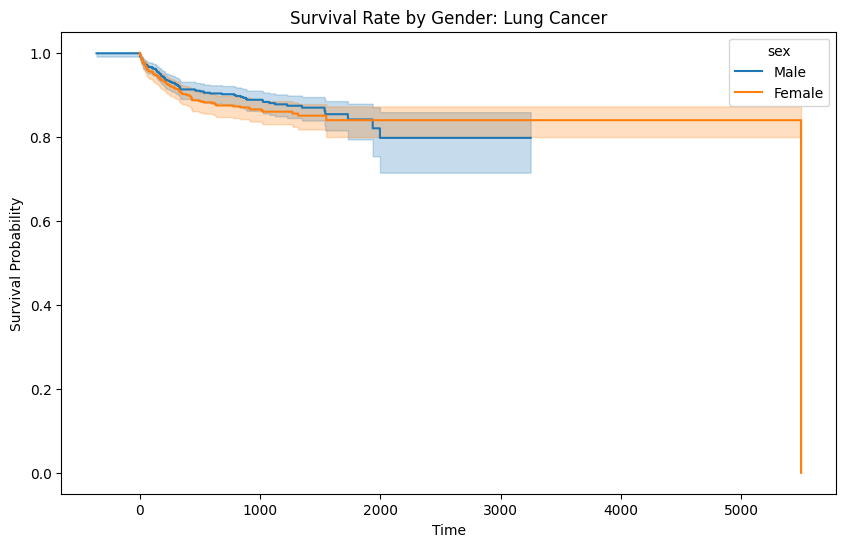

In [40]:
plot_survival_curves(lung_df, 'Survival_Time', 'Censored', 'sex', 'Survival Rate by Gender: Lung Cancer')

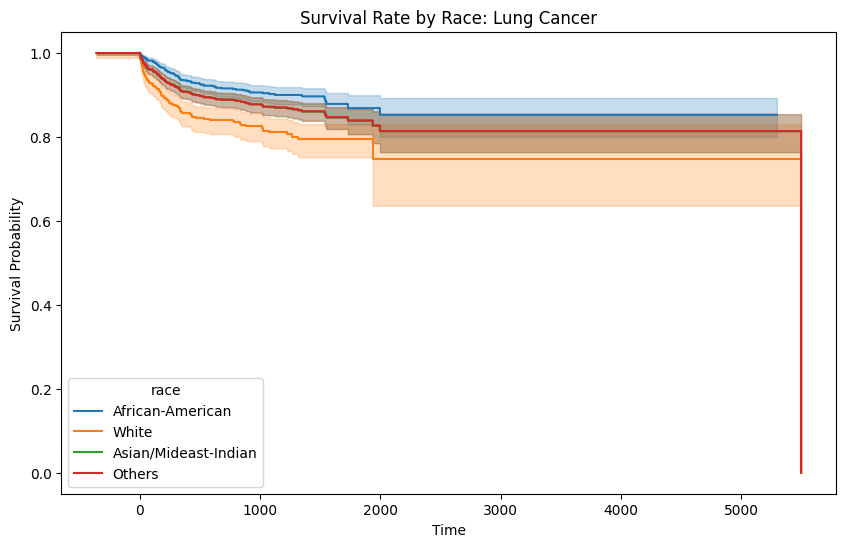

In [41]:
plot_survival_curves(lung_df, 'Survival_Time', 'Censored', 'race', 'Survival Rate by Race: Lung Cancer')

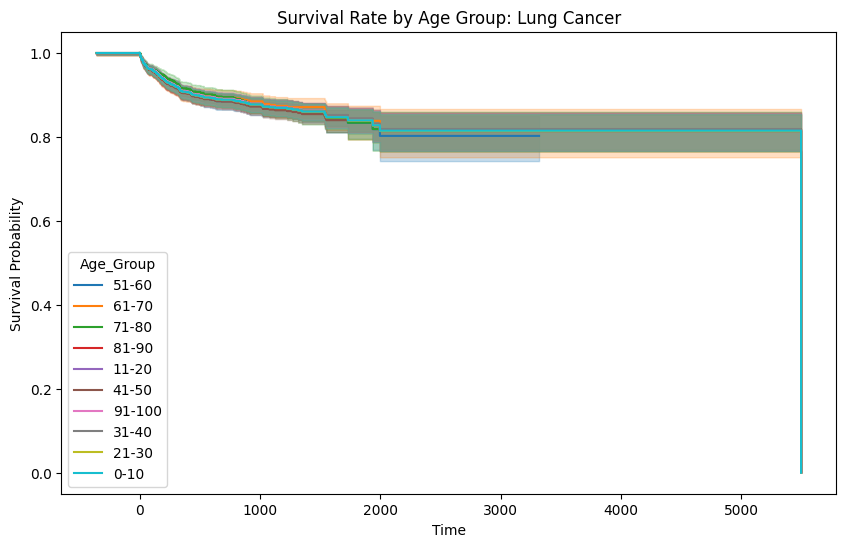

In [42]:
plot_survival_curves(lung_df, 'Survival_Time', 'Censored', 'Age_Group', 'Survival Rate by Age Group: Lung Cancer')

### Pancreas

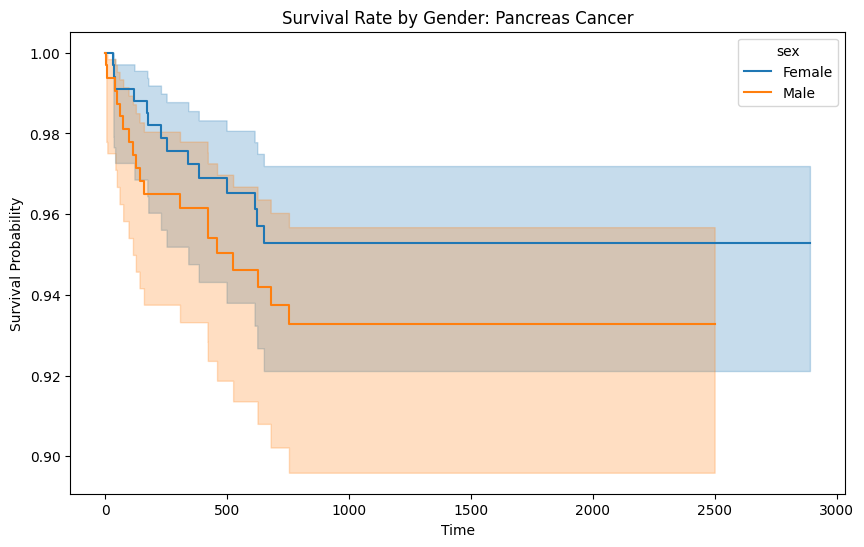

In [43]:
plot_survival_curves(pancreas_df, 'Survival_Time', 'Censored', 'sex', 'Survival Rate by Gender: Pancreas Cancer')

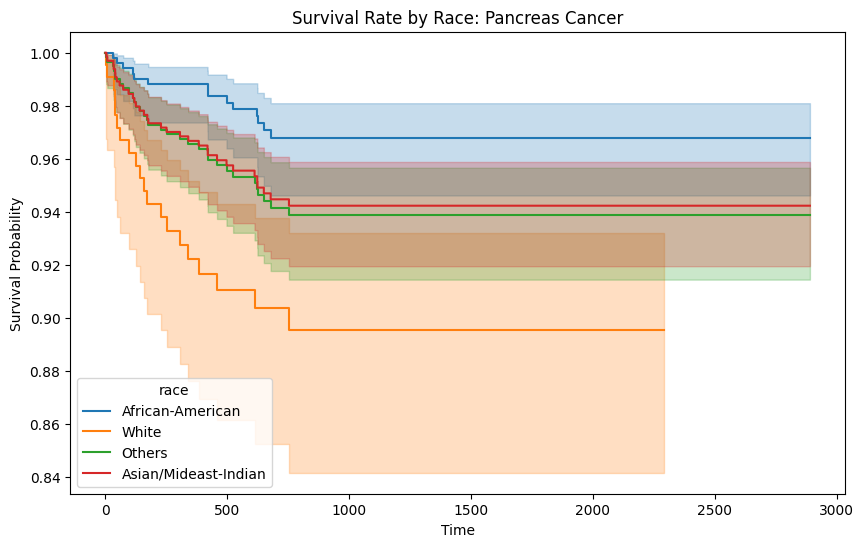

In [44]:
plot_survival_curves(pancreas_df, 'Survival_Time', 'Censored', 'race', 'Survival Rate by Race: Pancreas Cancer')

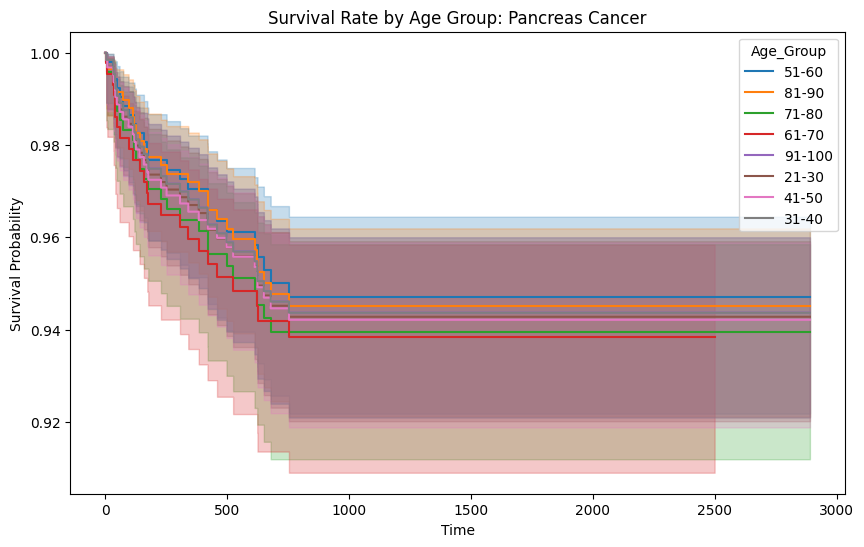

In [45]:
plot_survival_curves(pancreas_df, 'Survival_Time', 'Censored', 'Age_Group', 'Survival Rate by Age Group: Pancreas Cancer')

### Thyriod

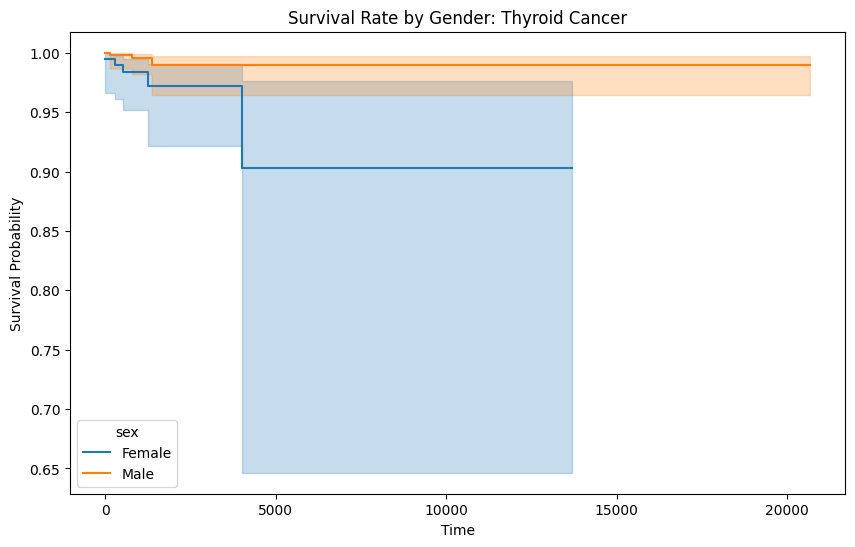

In [46]:
plot_survival_curves(thyroid_df, 'Survival_Time', 'Censored', 'sex', 'Survival Rate by Gender: Thyroid Cancer')

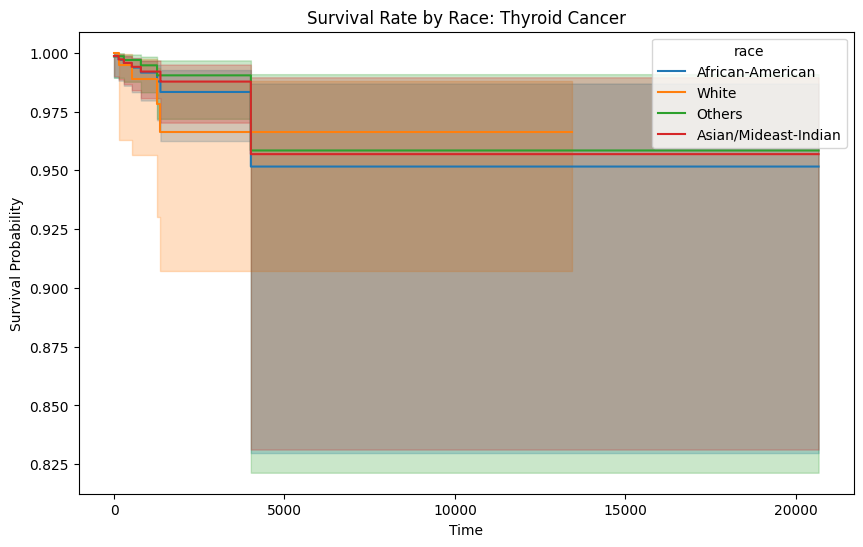

In [47]:
plot_survival_curves(thyroid_df, 'Survival_Time', 'Censored', 'race', 'Survival Rate by Race: Thyroid Cancer')

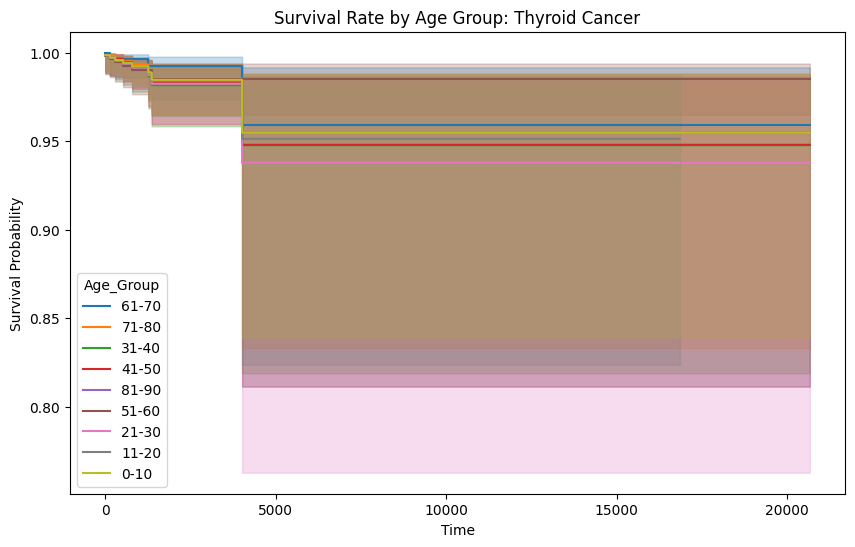

In [48]:
plot_survival_curves(thyroid_df, 'Survival_Time', 'Censored', 'Age_Group', 'Survival Rate by Age Group: Thyroid Cancer')

### Colorectal

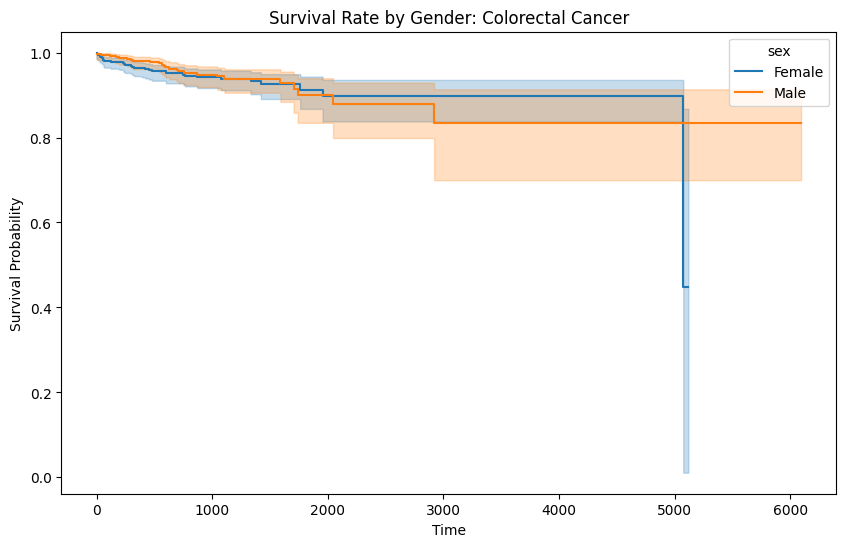

In [49]:
plot_survival_curves(colorectal_df, 'Survival_Time', 'Censored', 'sex', 'Survival Rate by Gender: Colorectal Cancer')

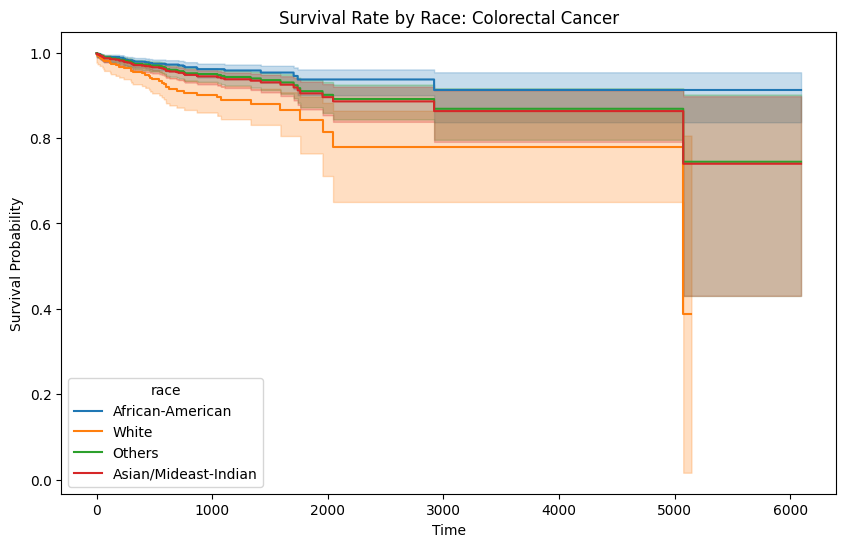

In [50]:
plot_survival_curves(colorectal_df, 'Survival_Time', 'Censored', 'race', 'Survival Rate by Race: Colorectal Cancer')

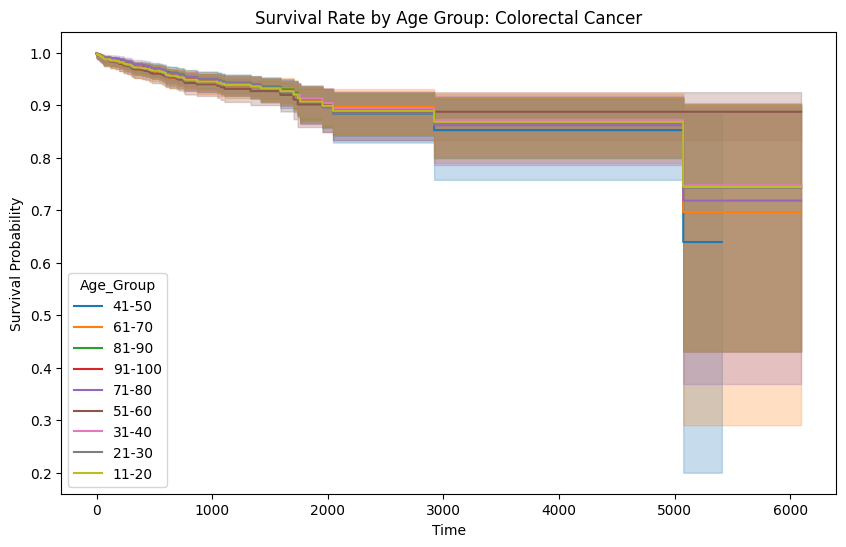

In [51]:
plot_survival_curves(colorectal_df, 'Survival_Time', 'Censored', 'Age_Group', 'Survival Rate by Age Group: Colorectal Cancer')

### Melanoma

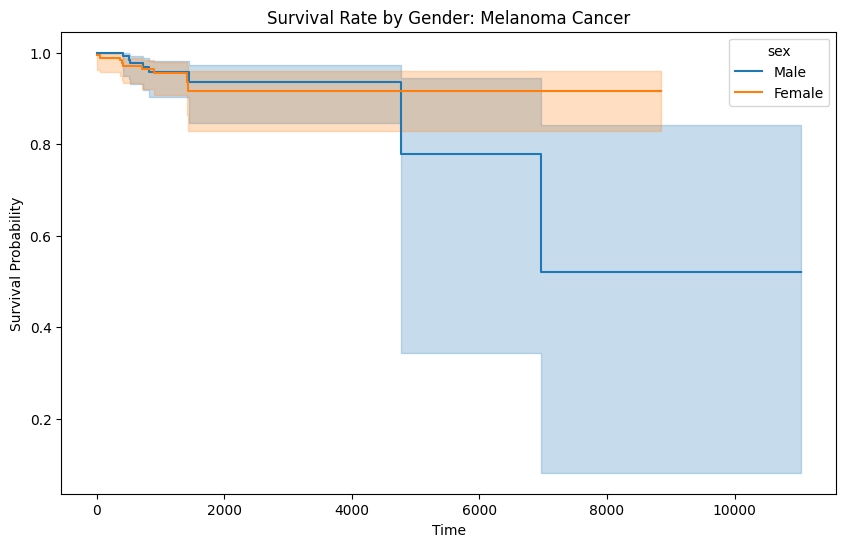

In [52]:
plot_survival_curves(melanoma_df, 'Survival_Time', 'Censored', 'sex', 'Survival Rate by Gender: Melanoma Cancer')

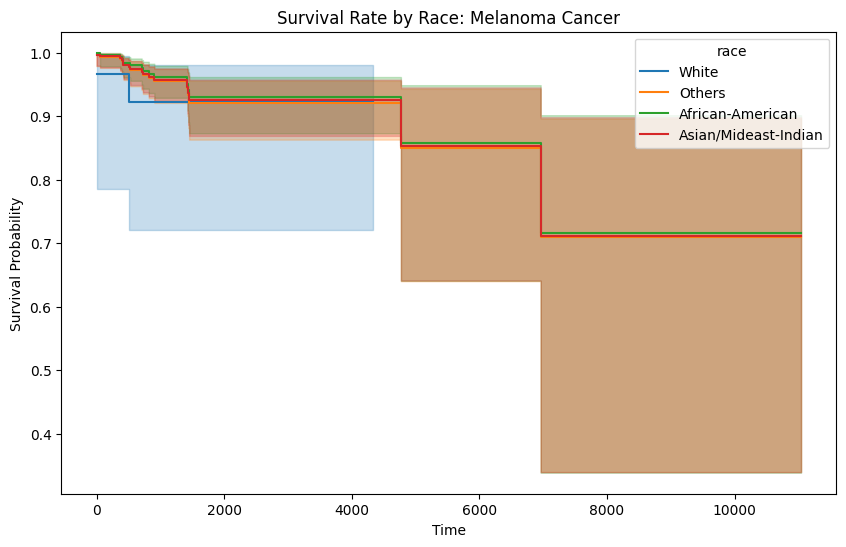

In [53]:
plot_survival_curves(melanoma_df, 'Survival_Time', 'Censored', 'race', 'Survival Rate by Race: Melanoma Cancer')

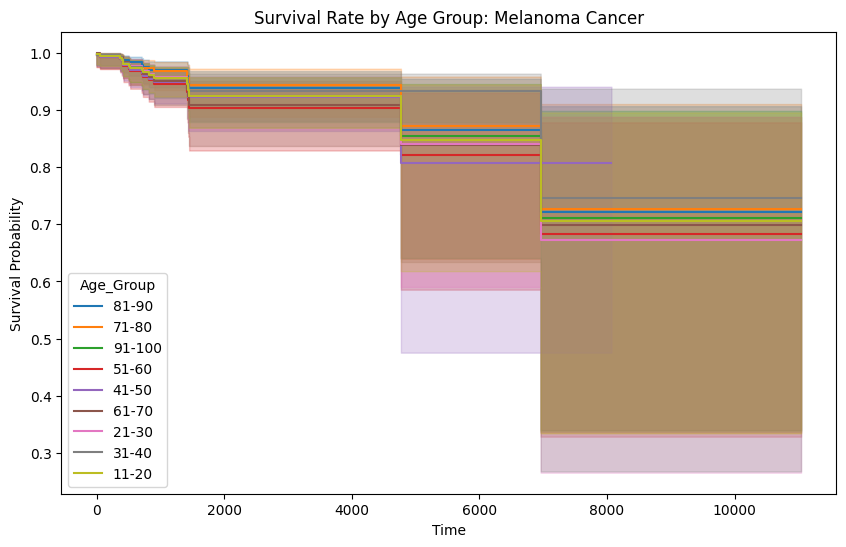

In [54]:
plot_survival_curves(melanoma_df, 'Survival_Time', 'Censored', 'Age_Group', 'Survival Rate by Age Group: Melanoma Cancer')

## 1. which cancer has the highest survival for this cohort?
## 2. which cancer has the lowest survival for this cohort?

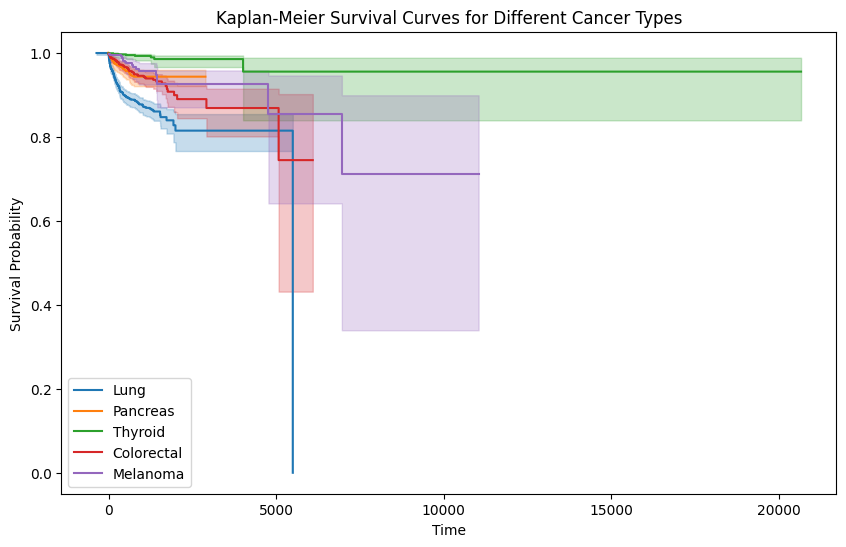

In [55]:
cancer_types = ['Lung', 'Pancreas', 'Thyroid', 'Colorectal', 'Melanoma']
cancer_dfs = [lung_df, pancreas_df, thyroid_df, colorectal_df, melanoma_df]

# Plot Kaplan-Meier curves for each cancer type
plt.figure(figsize=(10, 6))

for i, cancer_df in enumerate(cancer_dfs):
    kmf = KaplanMeierFitter()
    kmf.fit(durations=cancer_df['Survival_Time'], event_observed=cancer_df['Censored'], label=cancer_types[i])
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Survival Curves for Different Cancer Types')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend()

plt.show()

The above plot show the survival curves for each cancer type. The cancer type with the curve that stays higher for a longer duration indicates better survival and the one with curve that start descending earlier has lower survival.

**From the above plot, we can see that Thyroid cancer has the highest survival and Lung cancer has the lowest survival for this cohort.**

## 3. how many patients had 2 cancer diagnosis?

In [ ]:
print(f'There are {len(patient_data[patient_data["Cancer_count"] == 2])} patients who had 2 cancer diagnosis')

There are 29 patients who had 2 cancer diagnosis


## 4. which age group has the lowest survival after 400 days since cancer diagnosis?

In [ ]:
cancer_types_dfs = [lung_df, pancreas_df, thyroid_df, colorectal_df, melanoma_df]

# Combine separate DataFrames for each cancer type
all_cancers_df = pd.concat(cancer_types_dfs, ignore_index=True)

kmf = KaplanMeierFitter()

# Unique age groups in your DataFrame
unique_age_groups = all_cancers_df['Age_Group'].unique()

# Store survival rates for each age group
survival_rates = {}

# Iterate through each age group
for age_group in unique_age_groups:
    age_group_df = all_cancers_df[all_cancers_df['Age_Group'] == age_group]
    kmf.fit(age_group_df['Survival_Time'], event_observed=age_group_df['Censored'])

    # Predict the survival probability at 400 days
    survival_prob_at_400_days = kmf.predict(400)

    # Store the survival rate for each age group
    survival_rates[age_group] = survival_prob_at_400_days

# Identify the age group with the lowest survival rate at 400 days
lowest_survival_age_group = min(survival_rates, key=survival_rates.get)

print(f"The age group with the lowest survival after 400 days since cancer diagnosis is: {lowest_survival_age_group}")

The age group with the lowest survival after 400 days since cancer diagnosis is: 91-100


## 5. what is the survival rate for females with colorectal cancer after 1000 days since diagnosis?

In [ ]:
def survival_rate_after_days(data, time_col, event_col, group_col, days, group_value):
    kmf = KaplanMeierFitter()

    df = data[data[group_col] == group_value]
    kmf.fit(df[time_col], event_observed=df[event_col])

    #survival_probability_at_days = kmf.survival_function_at_times([days]).values[0]

    survival_probability_at_days= kmf.predict(days)

    return survival_probability_at_days

In [ ]:
survival_rate_female_colorectal = survival_rate_after_days(colorectal_df, 'Survival_Time', 'Censored', 'sex', 1000, 'Female')

print(f"The survival rate for females with colorectal cancer after 1000 days since diagnosis is: {survival_rate_female_colorectal:.2%}")

The survival rate for females with colorectal cancer after 1000 days since diagnosis is: 94.84%


## 6. what is the survival rate for males with lung cancer after 300 days since diagnosis?

In [ ]:
result = survival_rate_after_days(lung_df, 'Survival_Time', 'Censored', 'sex', 300, 'Male')

print(f"The survival rate for males with lung cancer after 300 days since diagnosis is: {result:.2%}")

The survival rate for males with lung cancer after 300 days since diagnosis is: 91.50%


## 7. what is the survival rate for females with melanoma cancer after 1200 days since diagnosis?

In [ ]:
result = survival_rate_after_days(melanoma_df, 'Survival_Time', 'Censored', 'sex', 1200, 'Female')

print(f"The survival rate for females with melanoma cancer after 1200 days since diagnosis is: {result:.2%}")

The survival rate for females with melanoma cancer after 1200 days since diagnosis is: 95.88%


## 8. what is the survival rate for males with thyroid cancer after 1500 days since diagnosis?

In [ ]:
result = survival_rate_after_days(thyroid_df, 'Survival_Time', 'Censored', 'sex', 1500, 'Male')

print(f"The survival rate for males with thyroid cancer after 1500 days since diagnosis is: {result:.2%}")

The survival rate for males with thyroid cancer after 1500 days since diagnosis is: 97.23%


## 9. what is the survival rate for males with pancreatic cancer after 2200 days since diagnosis?

In [ ]:
result = survival_rate_after_days(pancreas_df, 'Survival_Time', 'Censored', 'sex', 2200, 'Male')

print(f"The survival rate for males with pancreatic cancer after 2200 days since diagnosis is: {result:.2%}")

The survival rate for males with pancreatic cancer after 2200 days since diagnosis is: 95.28%


## 10. what is the survival rate for African-Americans with colorectal cancer after 2000 days since diagnosis?

In [ ]:
result = survival_rate_after_days(colorectal_df, 'Survival_Time', 'Censored', 'race', 2000, 'African-American')

print(f"The survival rate for African-Americans with colorectal cancer after 2000 days since diagnosis is: {result:.2%}")

The survival rate for African-Americans with colorectal cancer after 2000 days since diagnosis is: 77.07%


## 11. what is the survival rate for Whites with lung cancer after 1000 days since diagnosis?

In [ ]:
result = survival_rate_after_days(lung_df, 'Survival_Time', 'Censored', 'race', 1000, 'White')

print(f"The survival rate for Whites with lung cancer after 1000 days since diagnosis is: {result:.2%}")

The survival rate for Whites with lung cancer after 1000 days since diagnosis is: 90.93%


## 12. what is the survival rate for African-Americans with melanoma cancer after 2 years since diagnosis?

In [ ]:
result = survival_rate_after_days(melanoma_df, 'Survival_Time', 'Censored', 'race', 2*365, 'African-American')

print(f"The survival rate for African-Americans with melanoma cancer after 2 years since diagnosis is: {result:.2%}")

The survival rate for African-Americans with melanoma cancer after 2 years since diagnosis is: 82.54%


## 13. what is the survival rate for Whites with pancreatic cancer after 3 years since diagnosis?

In [ ]:
result = survival_rate_after_days(pancreas_df, 'Survival_Time', 'Censored', 'race', 3*365, 'White')

print(f"The survival rate for Whites with pancreatic cancer after 3 years since diagnosis is: {result:.2%}")

The survival rate for Whites with pancreatic cancer after 3 years since diagnosis is: 96.54%


## 14. what is the survival rate for Asians with thyroid cancer after 1500 days since diagnosis?

In [ ]:
result = survival_rate_after_days(thyroid_df, 'Survival_Time', 'Censored', 'race', 1500, 'Asian')

print(f"The survival rate for Asians with thyroid cancer after 1500 days since diagnosis is: {result:.2%}")

The survival rate for Asians with thyroid cancer after 1500 days since diagnosis is: 98.49%


## 15. which age group has the lowest survival for colorectal cancer at the end of the study?

In [ ]:
kmf = KaplanMeierFitter()

# Unique age groups in your DataFrame
unique_age_groups = colorectal_df['Age_Group'].unique()

# Store survival rates for each age group
survival_rates = {}

# Iterate through each age group
for age_group in unique_age_groups:
    age_group_df = colorectal_df[colorectal_df['Age_Group'] == age_group]
    kmf.fit(age_group_df['Survival_Time'], event_observed=age_group_df['Censored'])
    # Predict the survival probability at the end of the study
    survival_prob_at_end = kmf.predict(max(age_group_df['Survival_Time']))
    # Store the survival rate for each age group
    survival_rates[age_group] = survival_prob_at_end

# Identify the age group with the lowest survival rate at the end of the study
lowest_survival_age_group = min(survival_rates, key=survival_rates.get)

print(f"The age group with the lowest survival for colorectal cancer at the end of the study is: {lowest_survival_age_group}")

The age group with the lowest survival for colorectal cancer at the end of the study is: 51-60


## 16. which age group has the highest survival for lung cancer at the end of the study?

In [ ]:
kmf = KaplanMeierFitter()

# Unique age groups in your DataFrame
unique_age_groups = lung_df['Age_Group'].unique()

# Store survival rates for each age group
survival_rates = {}

# Iterate through each age group
for age_group in unique_age_groups:
    age_group_df = lung_df[lung_df['Age_Group'] == age_group]
    kmf.fit(age_group_df['Survival_Time'], event_observed=age_group_df['Censored'])
    # Predict the survival probability at the end of the study
    survival_prob_at_end = kmf.predict(max(age_group_df['Survival_Time']))
    # Store the survival rate for each age group
    survival_rates[age_group] = survival_prob_at_end

# Identify the age group with the highest survival rate at the end of the study
highest_survival_age_group = max(survival_rates, key=survival_rates.get)

print(f"The age group with the highest survival for lung cancer at the end of the study is: {highest_survival_age_group}")

The age group with the highest survival for lung cancer at the end of the study is: 21-30


## 17. what is the survival rate for 61-70 age group with melanoma cancer after 5 years since diagnosis?

In [ ]:
result = survival_rate_after_days(melanoma_df, 'Survival_Time', 'Censored', 'Age_Group', 5*365, '61-70')

print(f"The survival rate for 61-70 age group with melanoma cancer after 5 years since diagnosis is: {result:.2%}")

The survival rate for 61-70 age group with melanoma cancer after 5 years since diagnosis is: 97.40%


## 18. what is the survival rate for 21 - 30 age group with pancreatic cancer after a year since diagnosis?

In [ ]:
result = survival_rate_after_days(pancreas_df, 'Survival_Time', 'Censored', 'Age_Group', 365, '21-30')

print(f"The survival rate for 21 - 30 age group with pancreatic cancer after a year since diagnosis is: {result:.2%}")

The survival rate for 21 - 30 age group with pancreatic cancer after a year since diagnosis is: 100.00%


## 19. what is the survival rate for 51-60 age group with thyroid cancer after 2200 days since diagnosis?

In [ ]:
result = survival_rate_after_days(thyroid_df, 'Survival_Time', 'Censored', 'Age_Group', 2200, '51-60')

print(f"The survival rate for 51-60 age group with thyroid cancer after 2200 days since diagnosis is: {result:.2%}")

The survival rate for 51-60 age group with thyroid cancer after 2200 days since diagnosis is: 98.18%


## 20. which race has the high survival for all cancers after 2500 days since diagnosis?

In [ ]:
kmf = KaplanMeierFitter()

# Unique races in your DataFrame
unique_races = all_cancers_df['race'].unique()

# Store survival rates for each race
survival_rates = {}

# Iterate through each race
for race in unique_races:
    race_df = all_cancers_df[all_cancers_df['race'] == race]
    kmf.fit(race_df['Survival_Time'], event_observed=race_df['Censored'])
    # Predict the survival probability at 2500 days
    survival_prob_at_2500_days = kmf.predict(2500)
    # Store the survival rate for each race
    survival_rates[race] = survival_prob_at_2500_days

# Identify the race with the highest survival rate at 2500 days
highest_survival_race = max(survival_rates, key=survival_rates.get)

print(f"The race with the highest survival for all cancers after 2500 days since diagnosis is: {highest_survival_race}")

The race with the highest survival for all cancers after 2500 days since diagnosis is: White


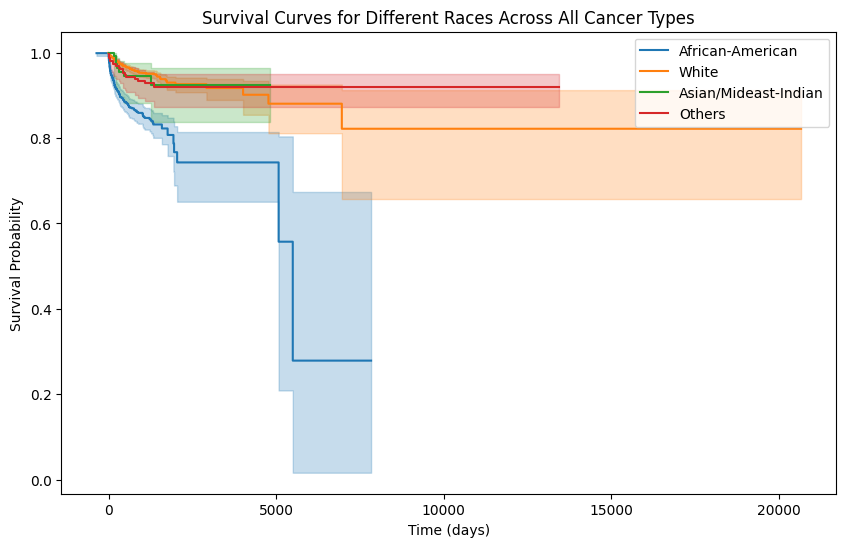

In [ ]:
kmf = KaplanMeierFitter()

# Unique races in your DataFrame
unique_races = all_cancers_df['race'].unique()

# Set up a matplotlib figure and axis
plt.figure(figsize=(10, 6))

# Iterate through each race
for race in unique_races:
    race_df = all_cancers_df[all_cancers_df['race'] == race]
    kmf.fit(race_df['Survival_Time'], event_observed=race_df['Censored'], label=race)
    kmf.plot_survival_function()

# Add labels and legend
plt.title('Survival Curves for Different Races Across All Cancer Types')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.legend()

# Show the plot
plt.show()